# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Import Data

In [2]:
# import data
import pandas as pd

raw_data = pd.read_csv('data.csv')
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Basic Data Cleansing

In [4]:
# cek NA/NULL
raw_data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
# remove NULL
raw_data = raw_data.dropna(axis = 0, how = 'any')

In [6]:
# cek duplicates
raw_data.duplicated().sum()

5225

In [7]:
# remove duplicates
raw_data = raw_data.drop_duplicates(ignore_index = True)

# Feature Engineering

In [8]:
# convert datetime column format
raw_data.InvoiceDate = pd.to_datetime(raw_data.InvoiceDate)

In [9]:
# create trx_amount col
raw_data['TrxAmount'] = raw_data.Quantity * raw_data.UnitPrice

# include only positive TrxAmount column (exclude credit)
raw_data = raw_data[raw_data['TrxAmount'] > 0]

In [10]:
# cast CustomerID col to interger
raw_data.CustomerID = raw_data.CustomerID.astype('int') 

In [11]:
# recency (r) df
data_r = raw_data[['InvoiceDate','CustomerID']].groupby('CustomerID')['InvoiceDate'].agg('max').reset_index()
data_r.head()

,CustomerID,InvoiceDate
0,12346,2011-01-18 10:01:00
1,12347,2011-12-07 15:52:00
2,12348,2011-09-25 13:13:00
3,12349,2011-11-21 09:51:00
4,12350,2011-02-02 16:01:00


In [12]:
# current time benchmark
cur_time = data_r.InvoiceDate.max()

# month diff function
def month_diff(cur_time, datetime_val): 
    return 12 * (cur_time.year - datetime_val.year) + (cur_time.month - datetime_val.month)

# recency month
data_r['Recency'] = data_r.InvoiceDate.apply(lambda datetime_val: month_diff(cur_time, datetime_val))

# clip max at 6 month
data_r.Recency = data_r.Recency.clip(lower = None, upper = 6)

# drop InvoiceDate col
data_r = data_r.drop('InvoiceDate', axis = 1)

# head
data_r.head()

,CustomerID,Recency
0,12346,6
1,12347,0
2,12348,3
3,12349,1
4,12350,6


In [30]:
# frequency & monetary(fm) df only w.r.t. last 6 month data
EARLIEST_DATE = pd.to_datetime('2011-06-09')
data_fm = raw_data[raw_data.InvoiceDate >= EARLIEST_DATE]
data_fm = data_fm[['InvoiceNo','CustomerID','TrxAmount']]

data_fm = data_fm.groupby('CustomerID')[['InvoiceNo','TrxAmount']].agg({'InvoiceNo':'nunique', 'TrxAmount':'mean'}).reset_index()
data_fm = data_fm.rename(columns = {'InvoiceNo':'Frequency', 'TrxAmount':'Monetary'})
data_fm.Monetary = data_fm.Monetary.round(2)
data_fm.head()

,CustomerID,Frequency,Monetary
0,12347,4,25.37
1,12348,1,103.33
2,12349,1,24.08
3,12352,3,20.09
4,12356,1,29.17


In [31]:
# join to have the final data df
data = data_r.merge(data_fm, on = 'CustomerID', how = 'left')
data = data.fillna(0)
data.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,6,0.0,0.00
1,12347,0,4.0,25.37
2,12348,3,1.0,103.33
3,12349,1,1.0,24.08
4,12350,6,0.0,0.00


In [32]:
# data df shape
data.shape

(4338, 4)

# K-means Clustering on RFM Features

## Standardize columns

In [33]:
from sklearn.preprocessing import StandardScaler

# feature columns
feature_cols = ['Recency','Frequency','Monetary']

# standardized df for training
standardized_data = data.copy()

# standardization
scaler = StandardScaler()
scaler.fit(data[feature_cols])
standardized_features = scaler.transform(data[feature_cols])
standardized_data[feature_cols] = standardized_features

## Elbow Method to Determine the Optimal K

In [34]:
# fit K-means clustering on various ks
from sklearn.cluster import KMeans

kmeans_kwargs = {
    "init" : "random",
    "n_init" : 10
}

sse = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(standardized_data[feature_cols])
    sse.append(kmeans.inertia_)

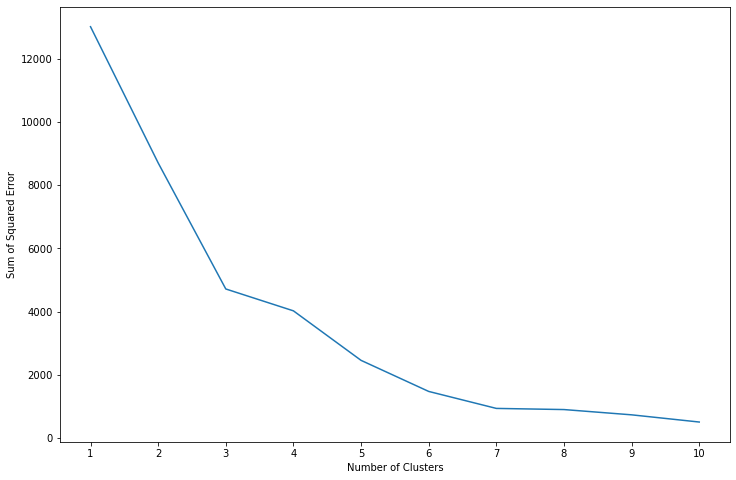

In [35]:
# Elbow method plot
import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Error")
plt.show()

# Fit K-meas using the optimal K = 3

In [39]:
# run kmeans with the optimal k
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(standardized_data[feature_cols])
data['cluster'] = kmeans.labels_
data.head()

,CustomerID,Recency,Frequency,Monetary,cluster
0,12346,6,0.0,0.00,1
1,12347,0,4.0,25.37,2
2,12348,3,1.0,103.33,2
3,12349,1,1.0,24.08,2
4,12350,6,0.0,0.00,1


# Analyze the resulted clusters

In [40]:
# look at the centroids per cluster
centroid_df = data.groupby('cluster')[['Recency', 'Frequency', 'Monetary','CustomerID']].agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary':'mean','CustomerID':'nunique'}).reset_index()
centroid_df = centroid_df.rename(columns = {'CustomerID':'NumBuyers'})
centroid_df

,cluster,Recency,Frequency,Monetary,NumBuyers
0,0,0.166667,25.712121,2636.807576,66
1,1,5.555718,0.493402,24.198798,1364
2,2,1.316713,2.873796,30.930024,2908


In [41]:
# give high-level name for each cluster
centroid_df.pop('cluster')

cluster_names = ['Top Buyers','Churned Buyers','Casual Buyers']
centroid_df['ClusterName'] = cluster_names

centroid_df

,Recency,Frequency,Monetary,NumBuyers,ClusterName
0,0.166667,25.712121,2636.807576,66,Top Buyers
1,5.555718,0.493402,24.198798,1364,Churned Buyers
2,1.316713,2.873796,30.930024,2908,Casual Buyers
